# Predicting Power Outage Severity 

**Name**: Essie Cheng

**Website Link**: https://essiecheng.github.io/Power-Outages-Prediction/

## Code

In [240]:
import pandas as pd
import numpy as np
import os

import plotly.express as px
pd.options.plotting.backend = 'plotly'

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, Binarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

### Framing the Problem

#### Prediction problem: Predict the severity of a major power outage in terms of its duration
This is a regression problem to predict the outage duration of a power outages.

#### Response variable: 'OUTAGE.DURATION'⏱️
The model will try to predict 'OUTAGE.DURATION', a continuous numerical variable that describes how long a power outage lasted (in minutes). This is chosen as the reponse variable because it directly reflects the outage impact's extent as outages that last longer are more "severe".

#### Evaluation Metric: RMSE
Valid evaluation metrics for regression models include RMSE and R^2. The RMSE assesses how well a regression model predicts the value of the response variable in absolute terms while R^2 does so in percentage terms. Because we want to evaluate the model's ability to generalize to unseen data, RMSE is chosen over R^2 as the evaluation metric as it gives a better assessment in how well the model will perform for unseen observations. The lower the RMSE, the better the predictions.

#### Load in Dataset

In [241]:
# code from project 3
outages_df = pd.read_csv(os.path.join('data', 'outage.xlsx - Masterdata.csv'))
outages_df.head()

,Major power outage events in the continental U.S.,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56
0,Time period: January 2000 - July 2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Regions affected: Outages reported in this dat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,variables,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND


#### Data Cleaning: 
The same data cleaning performed in project 3 will be performed here (and thus the following data cleaning code is from project 3)
- Fix Formatting
    - It appears that due to formatting issues: 
    - the first 4 rows are all NaN values 
    - the correct column names appear in row 5
    - These rows will be dropped and colum names will be reassigned.
- Typecasting
    - All columns are stored as strings, but it would make more sense for numerical information to be stored as floats.
    - It would be preferable if the power outages start date and time were merged into one pd.Timestamp column, and power outages restoration date and time were merged into one pd.Timestamp column.
- Fill in missing values
  - The response variable 'OUTAGE.DURATION' has 58 NaN values, so median imputation will be performed because its distribution is skewed.
- Keeping relevant columns
    - The DataFrame now has 57 columns. Since we're concerned with predicting the severity of a power outage from other power outage features, we only need columns in the dataset that include information related outage severity and other potentially contextual variables. We also only want information we would know at the time of prediction, so no columns that contain information that could only be known after a power outage will be included.
    - The chosen relevant columns are:
      - YEAR: Indicates the year when the outage event occurred
      - MONTH: Indicates the month when the outage event occurred
      - U.S._STATE: Represents all the states in the continental U.S.
      - POSTAL.CODE: Represents the postal code of the U.S. states
      - NERC.REGION: The North American Electric Reliability Corporation (NERC) regions involved in the outage event
      - CLIMATE.REGION: U.S. Climate regions as specified by National Centers for Environmental Information (nine climatically consistent regions in continental U.S.A.)
      - CLIMATE.CATEGORY: This represents the climate episodes corresponding to the years. The categories—“Warm”, “Cold” or “Normal” episodes of the climate are based on a threshold of ± 0.5 °C for the Oceanic Niño Index (ONI)
      - OUTAGE.START.DATE: This variable indicates the day of the year when the outage event started (as reported by the corresponding Utility in the region)
      - OUTAGE.START.TIME: This variable indicates the time of the day when the outage event started (as reported by the corresponding Utility in the region)
      - OUTAGE.RESTORATION.DATE: This variable indicates the day of the year when power was restored to all the customers (as reported by the corresponding Utility in the region)
      - OUTAGE.RESTORATION.TIME: This variable indicates the time of the day when power was restored to all the customers (as reported by the corresponding Utility in the region)
      - CAUSE.CATEGORY: Categories of all the events causing the major power outages
      - CAUSE.CATEGORY.DETAIL: Detailed description of the event categories causing the major power outages
      - OUTAGE.DURATION: Duration of outage events (in minutes)
      - PI.UTIL.OFUSA: State utility sector׳s income (earnings) as a percentage of the total earnings of the U.S. utility sector׳s income (in %)
      - TOTAL.CUSTOMERS: Annual number of total customers served in the U.S. state

In [297]:
# fix formatting
df = outages_df.copy()
df.columns = list(df.iloc[4])
df = df[6:]
df = df.reset_index()
df = df.drop(columns = ['index', 'variables', 'OBS'])
df.head(6)

# typecasting
df['OUTAGE.DURATION'] = pd.to_numeric(df['OUTAGE.DURATION'])
df['YEAR'] = pd.to_numeric(df['YEAR'])
df['MONTH'] = pd.to_numeric(df['MONTH'])
df['CUSTOMERS.AFFECTED'] = pd.to_numeric(df['CUSTOMERS.AFFECTED'])
df['TOTAL.CUSTOMERS'] = pd.to_numeric(df['TOTAL.CUSTOMERS'])

df['OUTAGE.START'] = df['OUTAGE.START.DATE'] + ' ' + df['OUTAGE.START.TIME']
df['OUTAGE.START'] = pd.to_datetime(df['OUTAGE.START'], format='%A, %B %d, %Y %I:%M:%S %p')

df['OUTAGE.RESTORATION'] = df['OUTAGE.RESTORATION.DATE'] + ' ' + df['OUTAGE.RESTORATION.TIME']
df['OUTAGE.RESTORATION'] = pd.to_datetime(df['OUTAGE.RESTORATION'], format='%A, %B %d, %Y %I:%M:%S %p')

# fill in missing values
med = np.nanmedian(df['OUTAGE.DURATION'])
df['OUTAGE.DURATION'] = df['OUTAGE.DURATION'].fillna(med)

# keeping relevant columns
columns = [
    'U.S._STATE', 
    'POSTAL.CODE', 
    'NERC.REGION', 
    'CLIMATE.REGION', 
    'OUTAGE.START', 
    'OUTAGE.DURATION', 
    'YEAR',
    'MONTH',
    'CAUSE.CATEGORY', 
    'CAUSE.CATEGORY.DETAIL',
    'CLIMATE.CATEGORY',
    'PI.UTIL.OFUSA',
    'TOTAL.CUSTOMERS'
]
df = df[columns]
df.head()

,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,OUTAGE.START,OUTAGE.DURATION,YEAR,MONTH,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,CLIMATE.CATEGORY,PI.UTIL.OFUSA,TOTAL.CUSTOMERS
0,Minnesota,MN,MRO,East North Central,2011-07-01 17:00:00,3060.0,2011,7.0,severe weather,NaN,normal,2.2,2595696
1,Minnesota,MN,MRO,East North Central,2014-05-11 18:38:00,1.0,2014,5.0,intentional attack,vandalism,normal,2.2,2640737
2,Minnesota,MN,MRO,East North Central,2010-10-26 20:00:00,3000.0,2010,10.0,severe weather,heavy wind,cold,2.1,2586905
3,Minnesota,MN,MRO,East North Central,2012-06-19 04:30:00,2550.0,2012,6.0,severe weather,thunderstorm,normal,2.2,2606813
4,Minnesota,MN,MRO,East North Central,2015-07-18 02:00:00,1740.0,2015,7.0,severe weather,NaN,warm,2.2,2673531


Now that the data is cleaned, a baseline model can be built.

### Baseline Model

#### Model
The model used in this prediciton task will be a **RandomForestRegressor**, a model suitable for regression and relatively robust to overfitting, therefore performing better on unseen data.

#### Features
In previous exploration of the dataset, it was found that certain regions have longer power outages. Thus, it seems that locational factors could be related to outage duration. The selected features for the model are:
- **'CLIMATE.REGION'** 🗺️
  > U.S. Climate regions as specified by National Centers for Environmental Information (nine climatically consistent regions in continental U.S.A.)
  
  > This is a nominal categorical variable

- **'NERC.REGION'** 📍
  > The North American Electric Reliability Corporation (NERC) regions involved in the outage event
  
  > This is a nominal categorical variable

These columns provide relevant locational information and are accessible at the time of prediction.

#### Feature Engineering
Since 'CLIMATE.REGION' and 'NERC.REGION' are both nominal categorical variables, they will be converted into numerical representations so that are suitable to predict 'OUTAGE.DURATION'.
- **'CLIMATE.REGION'** 🗺️: One-Hot Encoding

One-hot encoding will transform the single categorical feature into multiple numerical features, creating binary columns for each unique category that indicate the presence or absence of that category in the data. The potential categories in 'CLIMATE.REGION' are: 'East North Central', 'Central', 'South', 'Southeast', 'Northwest', Southwest', 'Northeast', 'West North Central', and 'West'.
explanation 

- **'NERC.REGION'** 📍: One-Hot Encoding
  
The potential categories in 'NERC.REGION' are: 'MRO', 'SERC', 'RFC', 'ECAR', 'TRE', 'WECC', 'SPP', 'NPCC', 'FRCC', 'FRCC, SERC'

After one-hot encoding the 2 nominal categorical features, the baseline RandomForestRegressor model will use 19 discrete numerical features:
> CLIMATE.REGION (East North Central)🗺️

> CLIMATE.REGION (Central)🗺️

> CLIMATE.REGION (South)🗺️

> CLIMATE.REGION (Southeast)🗺️

> CLIMATE.REGION (Northwest)🗺️

> CLIMATE.REGION (Southwest)🗺️

> CLIMATE.REGION (Northeast)🗺️

> CLIMATE.REGION (West North Central)🗺️

> CLIMATE.REGION (West)🗺️

> NERC.REGION (MRO)📍

> NERC.REGION (SERC)📍

> NERC.REGION (RFC)📍

> NERC.REGION (ECAR)📍

> NERC.REGION (TRE)📍

> NERC.REGION (WECC)📍

> NERC.REGION (SPP)📍

> NERC.REGION (FRCC)📍

> NERC.REGION (NPCC)📍

> NERC.REGION (FRCC, SERC)📍


**Note**: The model will actually use 17 features, because for each original feature ('CLIMATE.REGION' and 'NERC.REGION'), the model will drop one one-hot encoded feature in order to prevent multicollinearity. Additionally, 'CLIMATE.REGION' has 6 missing values, a trivial portion of the dataset, so those rows will be dropped.

#### Model Performance

In [150]:
df = df.dropna(subset = ['CLIMATE.REGION'])

In [218]:
X_b = df[['CLIMATE.REGION', 'NERC.REGION']]
y_b = df['OUTAGE.DURATION']

# split into train and test set
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size = 0.2, random_state = 1)

# feature engineering
preproc = ColumnTransformer(
    transformers = [
        ('categorical_ohe', OneHotEncoder(drop = 'first', handle_unknown='ignore'), ['CLIMATE.REGION', 'NERC.REGION'])
    ],
    remainder = 'passthrough'
)

# build pipeline
pl = Pipeline([
    ('preprocessor', preproc), 
    ('mdl', RandomForestRegressor(max_depth = 3, n_estimators = 100, random_state = 42))
])

pl.fit(X_train_b, y_train_b)

train_preds_b = pl.predict(X_train_b)
test_preds_b = pl.predict(X_test_b)

# calculate rmse
train_rmse_b = mean_squared_error(y_train, train_preds_b, squared=False)

test_rmse_b = mean_squared_error(y_test, test_preds_b, squared=False)

print(f"Train RMSE: {train_rmse_b}")
print(f"Test RMSE: {test_rmse_b}")

Train RMSE: 4916.138668308378
Test RMSE: 8312.675770084086


In [219]:
train_vs_actual = pd.DataFrame({'Train Predicted Duration': train_preds_b, 'Actual Duration': y_train_b})
train_vs_actual

,Train Predicted Duration,Actual Duration
1484,1696.929466,1895.0
1279,1696.929466,4605.0
1152,1696.929466,249.0
914,4025.372307,1044.0
1505,1750.409304,103.0
...,...,...
718,2807.566034,11531.0
910,3434.796523,1637.0
1101,1696.929466,945.0
235,2778.693061,70.0


In [220]:
test_vs_actual = pd.DataFrame({'Test Predicted Duration': test_preds_b, 'Actual Duration': y_test_b})
test_vs_actual

,Test Predicted Duration,Actual Duration
1478,2986.133051,77.0
371,2807.566034,360.0
1157,1696.929466,5160.0
1034,4000.567202,182.0
1330,2675.564788,1337.0
...,...,...
81,4025.372307,2085.0
566,2849.537684,565.0
389,2807.566034,1020.0
1158,1696.929466,133.0


Both the train and test RMSE's are pretty high, and the test RMSE is double the train RMSE. This indicates that the model's predictive ability is weak and the model is overfit to the current data. The model's "bad" performance can be attributed to the limited number of features (only 2 features) and limited characteristics of features (only locational characteristics). Since no search for the best hyperparameters was performed, the model may have also been affected by bad hyperparameters. It'd be beneficial to consider other features and better hyperparameter configurations, so a final model (with those changes implemented) will be built upon the baseline model to see if predictions for power outage duration can improve.

### Final Model

A **RandomForestRegressor** model will continue to be used, but the model’s performance will be further improved through additional steps like:
- Additional feature engineering: extracting more information and insights will improve the model's predictive ability
- Hyperparameter tuning: choosing appropriate hyperparameter values that minimize the loss function better will allow the model to provide more optimal results


#### Features

In additon to location, there may be many other factors that affect outage duration. It could be beneficial to add features that include economic characteristics, electricity consumption characteristics, weather characteristics, causal characteristics, etc. The features chosen for the final model are: 
- **'CLIMATE.REGION'🗺️**
    > see baseline model
- **'NERC.REGION'📍**
    > see baseline model
- **'CAUSE.CATEGORY'🚨**
    > Categories of all the events causing the major power outages

    > This is a nominal categorical variable
    
This feature could be useful because certain severe causes (e.g. severe weather) might cause longer outage durations than less severe causes (e.g. public appeal)
   
- **'CLIMATE.CATEGORY'🌤️**
    > This represents the climate episodes corresponding to the years. The categories—“Warm”, “Cold” or “Normal” episodes of the climate are based on a threshold of ± 0.5 °C for the Oceanic Niño Index (ONI)
    
    > This is an ordinal categorical variable

This feature could be useful because certain temperatures might affect power outages, as outages often occur during extremely hot or cold weather.

- **'PI.UTIL.OFUSA'💲**
    > State utility sector׳s income (earnings) as a percentage of the total earnings of the U.S. utility sector׳s income (in %)

    > This is a continous numerical variable

The distribution of power infrastructure earnings across different areas could give insight into economic influences on outage duration.

- **'TOTAL.CUSTOMERS'👥**
    > Annual number of total customers served in the U.S. state
    
    > This is a discrete numerical variable

This feature could provide relevant information about electricity consumption.

#### Feature Engineering
2 categorical features were added, so they will undergo transformations into numerical features. 2 numerical features were added, but with different units of measurements; to attain consistency and dull the dominace of features with larger values, they will undergo transformations to handle the different scales and magnitudes.

- **'CLIMATE.REGION'🗺️**: One-Hot Encoding

same as baseline model

- **'NERC.REGION'📍**: One-Hot Encoding

same as baseline model

- **'CAUSE.CATEGORY'🚨**: One-Hot Encoding

The potential one-hot encoded categories in 'CAUSE.CATEGORY' are: 'severe weather', 'intentional attack', 'system operability disruption', 'equipment failure', 'public appeal', 'fuel supply emergency', and 'islanding'.

- **'CLIMATE.CATEGORY'🌤️**: Ordinal Encoding

The categories of 'CLIMATE.CATEGORY' are 'normal', 'cold', 'warm; they will be assigned corresponding integers of natural ordering

- **'PI.UTIL.OFUSA'💲**: Scaled using StandardScalar

Scaling is applied for consistency and to prevent dominance by features with larger values

- **'TOTAL.CUSTOMERS'👥**: Scaled using StandardScalar

**Note**: For each original feature, the model will drop one one-hot encoded feature to prevent multicollinearity. Additionally, 'CLIMATE.CATEGORY' has a very trivial number of NaN values so those rows will be dropped.

#### Hyperparameters Searching
GridSearchCV will be used to obtain better hyperparamters and train more effectively. The combination tuned is **n_estimators, max_depth, min_samples_split,** and **max_features**. 

In [208]:
df = df.dropna(subset = ['CLIMATE.CATEGORY'])

In [222]:
X = df[['CLIMATE.REGION', 'NERC.REGION', 'CAUSE.CATEGORY', 'CLIMATE.CATEGORY', 'PI.UTIL.OFUSA', 'TOTAL.CUSTOMERS']]
y = df['OUTAGE.DURATION']


# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# feature engineering
preproc = ColumnTransformer(
    transformers = [
        ('categorical_ohe', OneHotEncoder(drop = 'first', handle_unknown='ignore'), ['CLIMATE.REGION', 'NERC.REGION', 'CAUSE.CATEGORY']),
        ('climate_ord', OrdinalEncoder(categories = [['normal', 'cold', 'warm']]), ['CLIMATE.CATEGORY']),
        ('quant_scale', StandardScaler(), ['PI.UTIL.OFUSA', 'TOTAL.CUSTOMERS'])
    ],
    remainder = 'passthrough'
)

# build pipeline
pl = Pipeline([
    ('preprocessor', preproc), 
    ('mdl', RandomForestRegressor(max_depth = 3, n_estimators = 100, random_state = 42))
])

# hyperparameter tuning
hyperparameters = {
    'mdl__n_estimators': np.arange(2, 200, 20),
    'mdl__max_depth': np.arange(2, 200, 20),
    'mdl__min_samples_split': [2, 5, 10],
    'mdl__max_features': ['auto', 'sqrt', 'log2']
}

grids = GridSearchCV(pl, hyperparameters, n_jobs=-1, cv=5)
grids.fit(X_train, y_train)

/Users/essiecheng/opt/anaconda3/envs/dsc80/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/essiecheng/opt/anaconda3/envs/dsc80/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/essiecheng/opt/anaconda3/envs/dsc80/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/essiecheng/opt/anaconda3/envs/dsc80/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  war

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical_ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['CLIMATE.REGION',
                                                                          'NERC.REGION',
                                                                          'CAUSE.CATEGORY']),
                                                                        ('climate_ord',
                                                                         OrdinalEncoder(categories=[['normal',
                                                                                                     'cold',
                                                                                                     'warm']]),
                                                                         ['CLIMATE.CATEGORY']),
                                                                        ('quant_scale',
                                                                         StandardScaler(),
                                                                         ['PI.UTIL.OFUSA',
                                                                          'TOTAL.CUSTOMERS'])])),
                                       ('mdl',
                                        RandomForestRegressor(max_depth=3,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'mdl__max_depth': array([  2,  22,  42,  62,  82, 102, 122, 142, 162, 182]),
                         'mdl__max_features': ['auto', 'sqrt', 'log2'],
                         'mdl__min_samples_split': [2, 5, 10],
                         'mdl__n_estimators': array([  2,  22,  42,  62,  82, 102, 122, 142, 162, 182])})

In [223]:
print("Best Hyperparameters:", grids.best_params_)

Best Hyperparameters: {'mdl__max_depth': 22, 'mdl__max_features': 'sqrt', 'mdl__min_samples_split': 10, 'mdl__n_estimators': 122}


#### Model Performance

In [224]:
train_preds = grids.predict(X_train)
test_preds = grids.predict(X_test)

train_rmse = mean_squared_error(y_train, train_preds, squared=False)
test_rmse = mean_squared_error(y_test, test_preds, squared=False)


print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 3593.13972810358
Test RMSE: 7954.385910146231


In [225]:
train = pd.DataFrame({
    'Baseline Train Predicted Duration': train_preds_b,
    'Final Train Predicted Duration': train_preds,
    'Actual Duration': y_train
})
train

,Baseline Train Predicted Duration,Final Train Predicted Duration,Actual Duration
1484,1696.929466,1064.502460,1895.0
1279,1696.929466,3291.529008,4605.0
1152,1696.929466,285.622604,249.0
914,4025.372307,5781.134054,1044.0
1505,1750.409304,499.433308,103.0
...,...,...,...
718,2807.566034,5081.982502,11531.0
910,3434.796523,4103.369718,1637.0
1101,1696.929466,633.132466,945.0
235,2778.693061,666.650876,70.0


In [226]:
test = pd.DataFrame({
    'Baseline Test Predicted Duration': test_preds_b,
    'Final Test Predicted Duration': test_preds,
    'Actual Duration': y_test
})
test

,Baseline Test Predicted Duration,Final Test Predicted Duration,Actual Duration
1478,2986.133051,44.929826,77.0
371,2807.566034,1187.522924,360.0
1157,1696.929466,6467.448835,5160.0
1034,4000.567202,1341.313430,182.0
1330,2675.564788,1323.058217,1337.0
...,...,...,...
81,4025.372307,1771.397739,2085.0
566,2849.537684,303.976274,565.0
389,2807.566034,1613.967306,1020.0
1158,1696.929466,552.294455,133.0


In [246]:
rmse = pd.DataFrame({
    'Train (Baseline)': [train_rmse_b],
    'Test (Baseline)': [test_rmse_b],
    'Train (Final)': [train_rmse],
    'Test (Final)': [test_rmse]
})

rmse = rmse.rename(index={0: 'RMSE'})
rmse

,Train (Baseline),Test (Baseline),Train (Final),Test (Final)
RMSE,4916.138668,8312.67577,3593.139728,7954.38591


The final model is considered an improvement, as both the training and testing RMSE are lower (training RMSE lowered by ~1300 minutes and testing RMSE lowered by ~400 minutes). However, the testing RMSE is still significantly higher than the training RMSE, indicating that the model is overfit to the training data (although the overfit is less extreme than in the baseline model). Overall, it appears that incorporating additional features (which include more information and help fit the model better) and optimizing hyperparameters enhanced the final model performance (although there are still limitations to the model's predictive ability).

### Fairness Analysis

To assess whether the model is fair, the test dataset is categorized into two groups: normal climate ('CLIMATE.CATEGORY' == 'normal') vs extreme climate ('CLIMATE.CATEGORY == 'warm' or 'cold'). To answer the question "Does my model perform worse for normal climates than it does for extreme climates?", a permutation test will be conducted. 

**Null Hypothesis**: The model is fair and its RMSE for both groups (normal vs hot/cold) is roughly the same, and any differences are due to random chance.

**Alternative Hypothesis**: The model is unfair and its RMSE for normal climates is higher than its RMSE for extreme climates.

**Test Statistic**: absolute difference in RMSE between the 'normal' and combined 'cold'/'hot' climate categories

**Significance level**: 0.05

In [287]:
# define groups based on 'CLIMATE.CATEGORY'
group_normal = X_test[X_test['CLIMATE.CATEGORY'] == 'normal']
group_extreme = X_test[(X_test['CLIMATE.CATEGORY'] == 'cold') | (X_test['CLIMATE.CATEGORY'] == 'warm')]

normal_y = y_test[df['CLIMATE.CATEGORY'] == 'normal']
extreme_y = y_test[(df['CLIMATE.CATEGORY'] == 'cold') | (df['CLIMATE.CATEGORY'] == 'warm')] 

# calculate observed rmse for each group
observed_rmse_normal = mean_squared_error(normal_y, grids.predict(group_normal), squared=False)
observed_rmse_extreme = mean_squared_error(extreme_y, grids.predict(group_extreme), squared=False)

# perform permutation testing
diffs = []
for i in range(1000):
    permuted_rmse_normal =  mean_squared_error(
        np.random.permutation(normal_y), 
        grids.predict(group_normal), 
        squared = False
    )
    permuted_rmse_extreme = mean_squared_error(
        np.random.permutation(extreme_y), 
        grids.predict(group_extreme), 
        squared=False
    )
    permuted_rmse_diff = np.abs(permuted_rmse_normal - permuted_rmse_extreme)
    diffs.append(permuted_rmse_diff)

observed_rmse_diff = np.abs(observed_rmse_normal - observed_rmse_extreme)
p_value = np.mean(np.array(diffs) >= observed_rmse_diff)

print(f"P-value: {p_value}")


P-value: 0.931


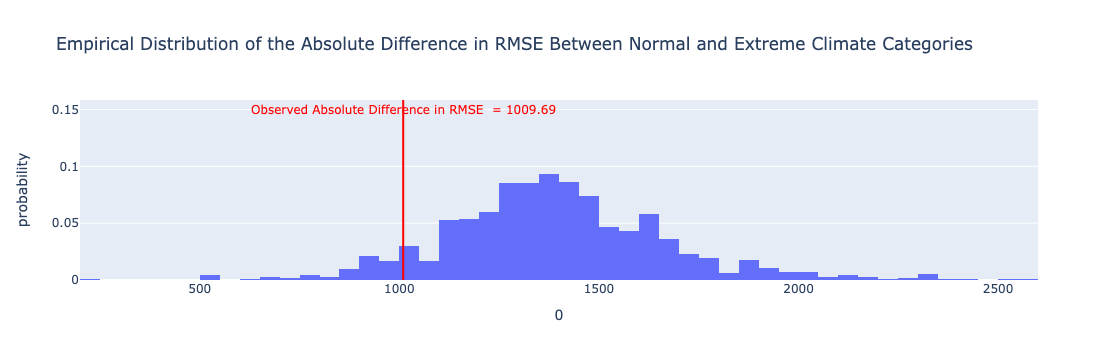

In [296]:
fig = px.histogram(
    pd.DataFrame(diffs), 
    x = 0, 
    nbins = 50,
    histnorm = 'probability',
    title='Empirical Distribution of the Absolute Difference in RMSE Between Normal and Extreme Climate Categories'
)
fig.add_vline(x = observed_rmse_diff, line_color = 'red')
fig.add_annotation(text=f'<span style="color:red">Observed Absolute Difference in RMSE  = {round(observed_rmse_diff, 2)}</span>',
                   x = observed_rmse_diff, showarrow=False, y=0.15)
fig.show()
fig.write_html('rmse_normal_vs_extreme.html', include_plotlyjs='cdn')

The resulting p-value of 0.931 leads us to fail to reject the null hypothesis and conclude that the model is fair. Of course, since statistical tests were performed and not randomized controlled trials, the results of the test aren't proven to be 100% true.